In [1]:
import pickle

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import uproot3_methods as uproot_methods
import networkx as nx
import glob
from matplotlib.colors import LogNorm
import pandas
import json
import sklearn
import sklearn.metrics
import bz2
import mpl_toolkits
import mplhep as hep
import itertools

plt.style.use(hep.style.ROOT)

/usr/local/lib/python3.6/dist-packages/awkward0/__init__.py:23: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  FutureWarning


In [2]:
def midpoints(x):
    return x[:-1] + np.diff(x)/2

def mask_empty(hist):
    h0 = hist[0].astype(np.float64)
    h0[h0<50] = 0
    return (h0, hist[1])

def divide_zero(a, b):
    a = a.astype(np.float64)
    b = b.astype(np.float64)
    out = np.zeros_like(a)
    np.divide(a, b, where=b>0, out=out)
    return out

pid_names = {
    0: "None",
    1: "Charged hadrons",
    2: "Neutral hadrons",
    3: "Photons",
    4: "Electrons",
    5: "Muons",
}

In [3]:
data = pickle.load(bz2.BZ2File("../data/pythia8_qcd/val/tev14_pythia8_qcd_10_0.pkl.bz2", "rb"))
data.keys()

dict_keys(['ygen_remaining', 'X', 'ycand', 'ygen'])

The dataset contains three main collections:
  - `X` - the list of reco object arrays (one `[Nobj x Nfeat_reco]` array per event)
  - `ycand` - the list of PFCandidate arrays (one `[Nobj x Nfeat_part]` array per event)
  - `ygen` - the list of GenParticles arrays (one `[Nobj x Nfeat_part]` array per event)
    

This file contains 100 events.

In [4]:
len(data["X"]), len(data["ycand"]), len(data["ygen"])

(100, 100, 100)

Let's look at the reco objects in the first event.

In [5]:
data["X"][0].shape

(5264, 12)

The X array contains 5264 reco objects(calo clusters and tracks concatenated to a single array) for this event, for each reco object we have the following features.

Calo cluster features:
  - 0: type=1
  - 1: transverse energy [GeV]
  - 2: eta
  - 3: sin(phi)
  - 4: cos(phi)
  - 5: total energy (GeV)
  - 6: electromagnetic energy (GeV)
  - 7: hadronic energy
  - 8-11: empty
  
Track features:
  - 0: type=2
  - 1: pT [GeV]
  - 2: eta
  - 3: sin(phi)
  - 4: cos(phi)
  - 5: P (GeV)
  - 6: eta_outer (GeV)
  - 7: sin(phi_outer)
  - 8: cos(phi_outer)
  - 9: charge
  - 10: is_gen_muon (set to 1 for tracks from generator muons to mimic Delphes PF)
  - 11: is_gen_electron (set to 1 for tracks from generator electrons to mimic Delphes PF)

In [6]:
data["ygen"][0].shape, data["ycand"][0].shape

((5264, 7), (5264, 7))

The GenParticle and PFCandidate arrays have the same features.

  - 0: PID code
    - PID==0: no particle
    - PID==1: charged hadron
    - PID==2: neutral hadron
    - PID==3: photon
    - PID==4: electron
    - PID==5: muon
  - 1: charge
  - 2: pT
  - 3: eta
  - 4: sin phi
  - 5: cos phi
  - 6: energy

## Event visualization

In [7]:
X = data["X"][0]
ycand = data["ycand"][0]
ygen = data["ygen"][0]

#Get masks for the tracks, ECAL and HCAL elements
msk_trk = X[:, 0] == 2
msk_ecal = (X[:, 0] == 1) & (X[:, 6] > 0)
msk_hcal = (X[:, 0] == 1) & (X[:, 7] > 0)

arr_trk = pandas.DataFrame(X[msk_trk], columns=["id", "pt", "eta", "sphi", "cphi", "p", "eta_outer", "sphi_outer", "cphi_outer", "charge", "is_gen_muon", "is_gen_ele"])
arr_ecal = pandas.DataFrame(X[msk_ecal][:, :6], columns=["id", "et", "eta", "sphi", "cphi", "e"])
arr_hcal = pandas.DataFrame(X[msk_hcal][:, :6], columns=["id", "et", "eta", "sphi", "cphi", "e"])

arr_gen = pandas.DataFrame(ygen[ygen[:, 0]!=0], columns=["id", "charge", "pt", "eta", "sphi", "cphi", "energy"])

#compute track x,y on the inner and outer surfaces
points_a = arr_trk["eta"].values, np.arctan2(arr_trk["sphi"], arr_trk["cphi"]).values
points_b = arr_trk["eta_outer"].values, np.arctan2(arr_trk["sphi_outer"], arr_trk["cphi_outer"]).values

r1 = 0.5
r2 = 1.0
r3 = 1.2
r4 = 1.4
r5 = 1.6

points = []
for i in range(len(arr_trk)):
    point = []
    point.append((0,0,0))
    point.append((points_a[0][i], r1*np.sin(points_a[1][i]), r1*np.cos(points_a[1][i])))
    point.append((points_b[0][i], r2*np.sin(points_b[1][i]), r2*np.cos(points_b[1][i])))
    points.append(point)
    
points_etaphi = []
for i in range(len(arr_trk)):
    point = []
    point.append((points_a[0][i], points_a[1][i]))
    point.append((points_b[0][i], points_b[1][i]))
    points_etaphi.append(point)
    
    
points_xyz = []
for i in range(len(arr_trk)):
    point = []
    point.append((0,0,0))
    point.append((r1*np.sinh(points_a[0][i]), r1*np.sin(points_a[1][i]), r1*np.cos(points_a[1][i])))
    point.append((r2*np.sinh(points_b[0][i]), r2*np.sin(points_b[1][i]), r2*np.cos(points_b[1][i])))
    points.append(point)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


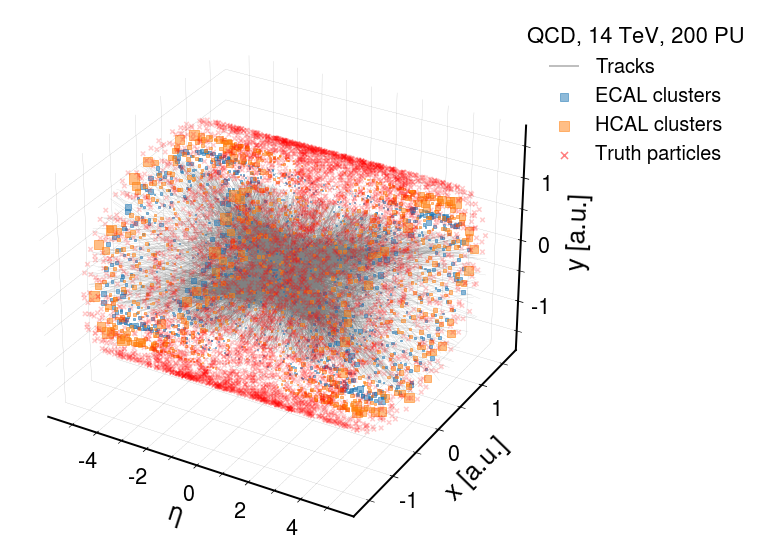

In [8]:
fig = plt.figure(figsize=(14,10))

plot_tracks = True 
plot_ecal = True
plot_hcal = True
plot_gen = True

ax = fig.add_subplot(111, projection='3d')

if plot_tracks:
    lc = mpl_toolkits.mplot3d.art3d.Line3DCollection(points, linewidths=0.2, color="gray", alpha=0.5)
    ax.add_collection(lc)
# just for better legend
lc2 = mpl_toolkits.mplot3d.art3d.Line3DCollection([], linewidths=2, color="gray", alpha=0.5, label="Tracks")
ax.add_collection(lc2)

if plot_ecal:
    ax.scatter(arr_ecal["eta"], r3*arr_ecal["sphi"], r3*arr_ecal["cphi"], s=0.1*arr_ecal["e"], color=u'#1f77b4', marker="s", alpha=0.5)
if plot_hcal:
    ax.scatter(arr_hcal["eta"], r4*arr_hcal["sphi"], r4*arr_hcal["cphi"], s=0.1*arr_hcal["e"], color=u'#ff7f0e', marker="s", alpha=0.5)
if plot_gen:    
    ax.scatter(arr_gen["eta"], r5*arr_gen["sphi"], r5*arr_gen["cphi"], alpha=0.2, marker="x", color="red")
# just for better legend
ax.scatter([],[], [], alpha=0.5, marker="s", s = 50, color=u'#1f77b4', label="ECAL clusters")
ax.scatter([],[], [], alpha=0.5, marker="s", s = 100, color=u'#ff7f0e', label="HCAL clusters")
ax.scatter([],[], [], alpha=0.5, marker="x", s = 50, color="red", label="Truth particles")


ax.set_zlabel(r"$y$ [a.u.]",labelpad=15)
ax.set_ylabel(r"$x$ [a.u.]",labelpad=15)
ax.set_xlabel(r"$\eta$",labelpad=15)

from matplotlib.ticker import MultipleLocator, AutoMinorLocator
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.zaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.zaxis.set_minor_locator(MultipleLocator(0.5))

ax.xaxis._axinfo["grid"].update({"linewidth":0.2, "color" : "gray", "which":"major", "linestyle":"--","alpha":0.1})
ax.yaxis._axinfo["grid"].update({"linewidth":0.2, "color" : "gray", "which":"major", "linestyle":"--","alpha":0.1})
ax.zaxis._axinfo["grid"].update({"linewidth":0.2, "color" : "gray", "which":"major", "linestyle":"--","alpha":0.1})

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.set_xlim(-5.75, 5.75)
ax.set_ylim(-1.75, 1.75)
ax.set_zlim(-1.75, 1.75)

legend = plt.legend(title =r"QCD, 14 TeV, 200 PU",frameon=False, bbox_to_anchor=(0.92, 1.0), loc='upper left',fontsize=20)
plt.setp(legend.get_title(),fontsize=22)
#plt.title("Simulated event with PU200")
plt.show()

## Particle multiplicities

Text(0, 1, 'Number of rule-based PF\nparticles per event')

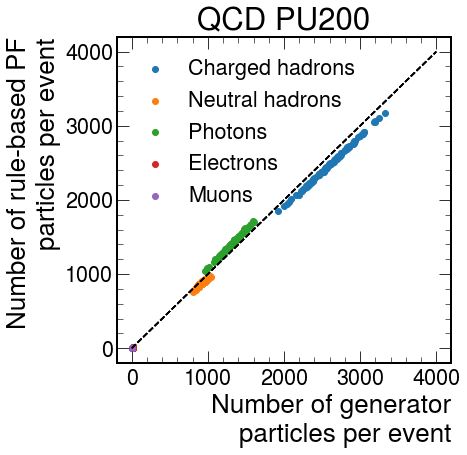

In [9]:
plt.figure(figsize=(6,6))
for pid in [1,2,3,4,5]:
    npid_gen = [np.sum(y[:, 0]==pid) for y in data["ygen"]]
    npid_cand = [np.sum(y[:, 0]==pid) for y in data["ycand"]]
    plt.scatter(npid_gen, npid_cand, label=pid_names[pid])
    plt.plot([0,4000],[0,4000], color="black", ls="--")
plt.legend()
plt.title("QCD PU200")
plt.xlabel("Number of generator\nparticles per event")
plt.ylabel("Number of rule-based PF\nparticles per event")

## GenParticle kinematics

In [10]:
X = np.concatenate(data["X"])
ygen = np.concatenate(data["ygen"])
ycand = np.concatenate(data["ycand"])

Text(0, 1, 'Truth particles')

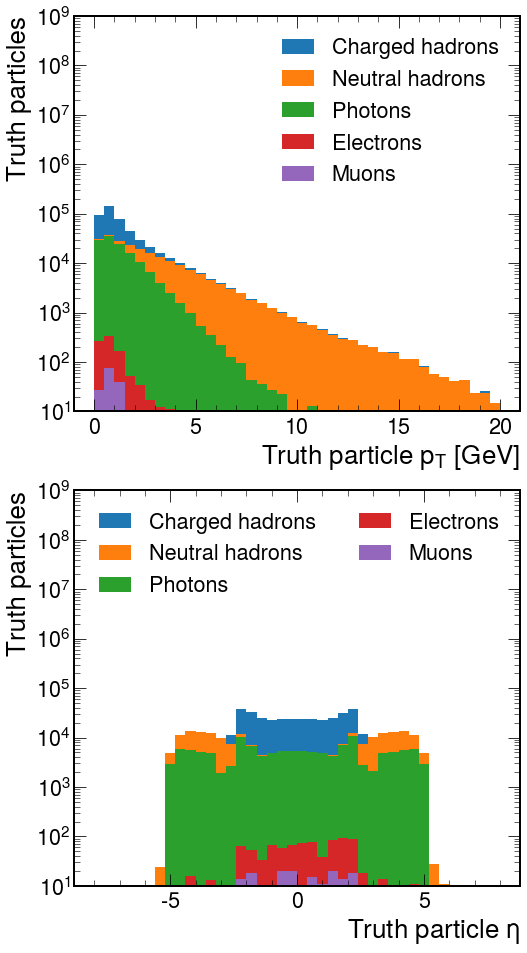

In [11]:
b = np.linspace(0, 20, 41)

msk_pid1 = (ygen[:, 0]==1)
msk_pid2 = (ygen[:, 0]==2)
msk_pid3 = (ygen[:, 0]==3)
msk_pid4 = (ygen[:, 0]==4)
msk_pid5 = (ygen[:, 0]==5)

h1 = np.histogram(ygen[msk_pid1, 2], bins=b)
h2 = np.histogram(ygen[msk_pid2, 2], bins=b)
h3 = np.histogram(ygen[msk_pid3, 2], bins=b)
h4 = np.histogram(ygen[msk_pid4, 2], bins=b)
h5 = np.histogram(ygen[msk_pid5, 2], bins=b)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 2*8))

xs = midpoints(h1[1])
width = np.diff(h1[1])

hep.histplot([h5[0], h4[0], h3[0], h2[0], h1[0]], bins=h1[1], ax=ax1, stack=True, histtype="fill",
    label=["Muons", "Electrons", "Photons", "Neutral hadrons", "Charged hadrons"])

ax1.legend(loc="best", frameon=False)
ax1.set_yscale("log")
ax1.set_ylim(1e1, 1e9)
ax1.set_xlabel(r"Truth particle $p_\mathrm{T}$ [GeV]")
ax1.set_ylabel("Truth particles")

b = np.linspace(-8, 8, 41)
h1 = np.histogram(ygen[msk_pid1, 3], bins=b)
h2 = np.histogram(ygen[msk_pid2, 3], bins=b)
h3 = np.histogram(ygen[msk_pid3, 3], bins=b)
h4 = np.histogram(ygen[msk_pid4, 3], bins=b)
h5 = np.histogram(ygen[msk_pid5, 3], bins=b)
xs = midpoints(h1[1])
width = np.diff(h1[1])

hep.histplot([h5[0], h4[0], h3[0], h2[0], h1[0]], bins=h1[1], ax=ax2, stack=True, histtype="fill",
    label=["Muons", "Electrons", "Photons", "Neutral hadrons", "Charged hadrons"])
ax2.legend(loc="best", frameon=False, ncol=2)
ax2.set_yscale("log")
ax2.set_ylim(1e1, 1e9)
ax2.set_xlabel("Truth particle $\eta$")
ax2.set_ylabel("Truth particles")

## Reco object to particle association

In [12]:
X_ygen_matrix = sklearn.metrics.confusion_matrix(
    X[:, 0], ygen[:, 0], labels=range(6)
)
X_ycand_matrix = sklearn.metrics.confusion_matrix(
    X[:, 0], ycand[:, 0], labels=range(6)
)

Text(0.5, 1.0, 'Reco object to GenParticle association')

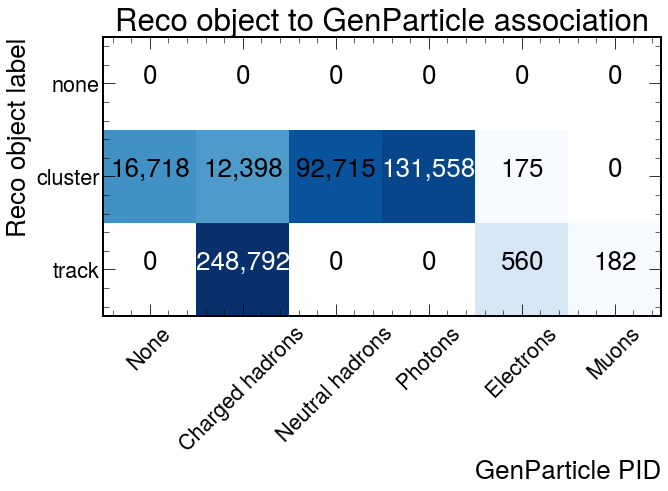

In [13]:
ax = plt.axes()
ax.imshow(X_ygen_matrix[:3, :], cmap="Blues", norm=matplotlib.colors.LogNorm())
ax.set_yticks(range(3))
ax.set_yticklabels(["none", "cluster", "track"])
ax.set_xticks(range(6))
ax.set_xticklabels([pid_names[p] for p in range(6)], rotation=45);
ax.set_xlabel("GenParticle PID")
ax.set_ylabel("Reco object label")

for i, j in itertools.product(range(3), range(6)):
    ax.text(j, i, "{:,}".format(X_ygen_matrix[i, j]),
             horizontalalignment="center",
             color="white" if X_ygen_matrix[i, j] > X_ygen_matrix.max()/2 else "black")
    
plt.title("Reco object to GenParticle association")


Text(0.5, 1.0, 'Reco object to PFCandidate association')

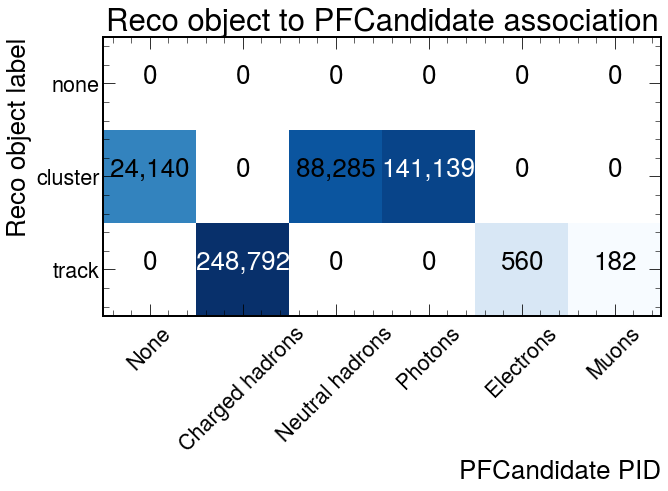

In [17]:
ax = plt.axes()
ax.imshow(X_ycand_matrix[:3, :], cmap="Blues", norm=matplotlib.colors.LogNorm())
ax.set_yticks(range(3))
ax.set_yticklabels(["none", "cluster", "track"])
ax.set_xticks(range(6))
ax.set_xticklabels([pid_names[p] for p in range(6)], rotation=45);
ax.set_xlabel("PFCandidate PID")
ax.set_ylabel("Reco object label")

for i, j in itertools.product(range(3), range(6)):
    ax.text(j, i, "{:,}".format(X_ycand_matrix[i, j]),
             horizontalalignment="center",
             color="white" if X_ycand_matrix[i, j] > X_ycand_matrix.max()/2 else "black")
    
plt.title("Reco object to PFCandidate association")

Text(1, 0, '$(\\eta_{reco} - \\eta_{ptcl}) / \\eta_{reco}$')

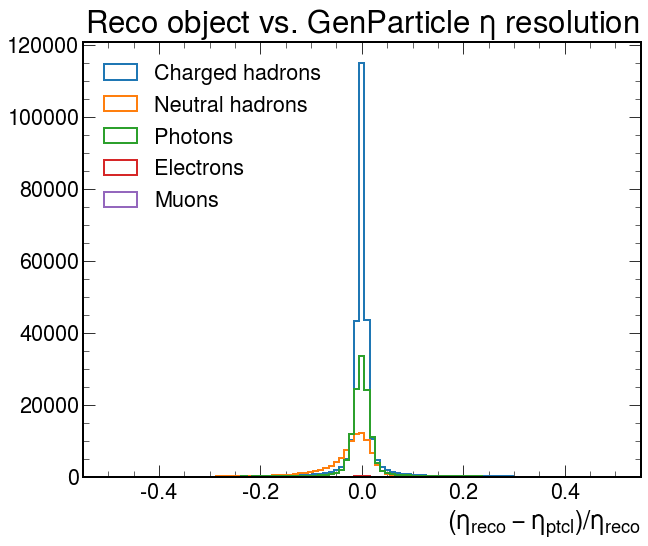

In [18]:
plt.figure(figsize=(10,8))
for pid in [1,2,3,4,5]:
    msk = ygen[:, 0] == pid
    eta_x = X[msk, 2]
    eta_y = ygen[msk, 3]
    plt.hist((eta_x-eta_y)/eta_x, bins=np.linspace(-0.5, 0.5, 100), histtype="step", lw=2, label=pid_names[pid])
plt.legend(loc=2)
plt.title("Reco object vs. GenParticle $\eta$ resolution")
plt.xlabel("$(\eta_{reco} - \eta_{ptcl}) / \eta_{reco}$")

Text(1, 0, '$(\\eta_{reco} - \\eta_{ptcl}) / \\eta_{reco}$')

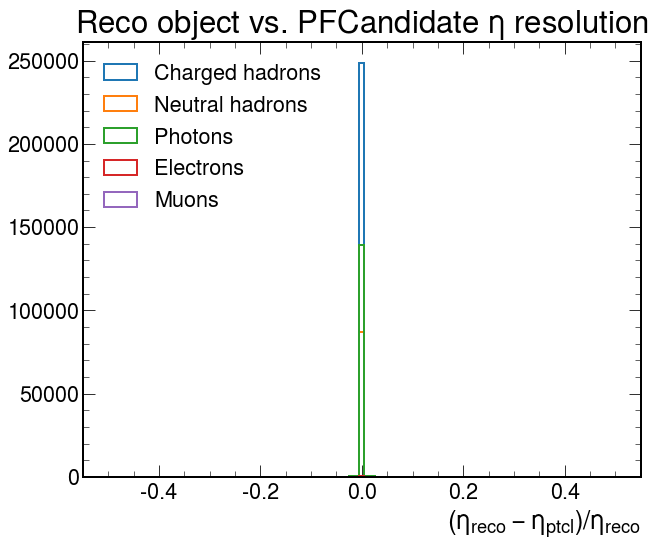

In [19]:
plt.figure(figsize=(10,8))
for pid in [1,2,3,4,5]:
    msk = ycand[:, 0] == pid
    eta_x = X[msk, 2]
    eta_y = ycand[msk, 3]
    plt.hist((eta_x-eta_y)/eta_x, bins=np.linspace(-0.5, 0.5, 100), histtype="step", lw=2, label=pid_names[pid])
plt.legend(loc=2)
plt.title("Reco object vs. PFCandidate $\eta$ resolution")
plt.xlabel("$(\eta_{reco} - \eta_{ptcl}) / \eta_{reco}$")